In [3]:
import rasterio 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
kathmandu_dataset_raster=rasterio.open(r"C:\Users\user\Downloads\GIS_self_project\Masked_composite_layer_kathmandu_raster\kathmadu_masked_layer_raster_20131.tif")

In [6]:
print(f"The shape of {kathmandu_dataset_raster.shape}")
print(f"The number of bands {kathmandu_dataset_raster.count}")
print(kathmandu_dataset_raster.height)
print(kathmandu_dataset_raster.width)
print(kathmandu_dataset_raster.transform)
print(kathmandu_dataset_raster.dtypes)
print(kathmandu_dataset_raster.crs)
print(kathmandu_dataset_raster.driver)

The shape of (929, 1252)
The number of bands 8
929
1252
| 30.00, 0.00, 321171.09|
| 0.00,-30.00, 3078324.32|
| 0.00, 0.00, 1.00|
('uint32', 'uint32', 'uint32', 'uint32', 'uint32', 'uint32', 'uint32', 'uint32')
EPSG:32645
GTiff


In [7]:
print(kathmandu_dataset_raster.meta)

{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 65536.0, 'width': 1252, 'height': 929, 'count': 8, 'crs': CRS.from_dict(init='epsg:32645'), 'transform': Affine(30.0, 0.0, 321171.09350611235,
       0.0, -30.0, 3078324.32021069)}


In [8]:
print(kathmandu_dataset_raster)

<open DatasetReader name='C:\Users\user\Downloads\GIS_self_project\Masked_composite_layer_kathmandu_raster\kathmadu_masked_layer_raster_20131.tif' mode='r'>


In [9]:

kathmandu_raster_array=kathmandu_dataset_raster.read([4,3,2])

print(kathmandu_raster_array.shape)
kathmandu_raster_array_band_4,kathmandu_raster_array_band_3,kathmandu_raster_array_band_2=kathmandu_dataset_raster.read([4,3,2])


print(kathmandu_raster_array_band_4.shape)
print(kathmandu_raster_array_band_3.shape)
print(kathmandu_raster_array_band_3.shape)

(3, 929, 1252)
(929, 1252)
(929, 1252)
(929, 1252)


Now normalisze the plot see the composite image

In [13]:
def normalize(band_in_array):
    maximum_value,minimum_value=np.max(band_in_array),np.min(band_in_array)
    normalize_band_array= (band_in_array-minimum_value)/(maximum_value-minimum_value)
    return(normalize_band_array)

In [14]:
kathmandu_raster_array_band_4_normalized=normalize(kathmandu_raster_array_band_4)
kathmandu_raster_array_band_3_normalized=normalize(kathmandu_raster_array_band_3)
kathmandu_raster_array_band_2_normalized=normalize(kathmandu_raster_array_band_2)

print(kathmandu_raster_array_band_4_normalized)
print(kathmandu_raster_array_band_4_normalized.mean())
print(kathmandu_raster_array_band_3_normalized.mean())
print(kathmandu_raster_array_band_2_normalized.mean())


# Now stack the band same before normalization
composite_normalized_RGB= np.dstack([kathmandu_raster_array_band_4_normalized,kathmandu_raster_array_band_3_normalized,kathmandu_raster_array_band_2_normalized])
composite_normalized_RGB.shape

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
0.6247102058935523
0.6222056695837046
0.6174946016939014


(929, 1252, 3)

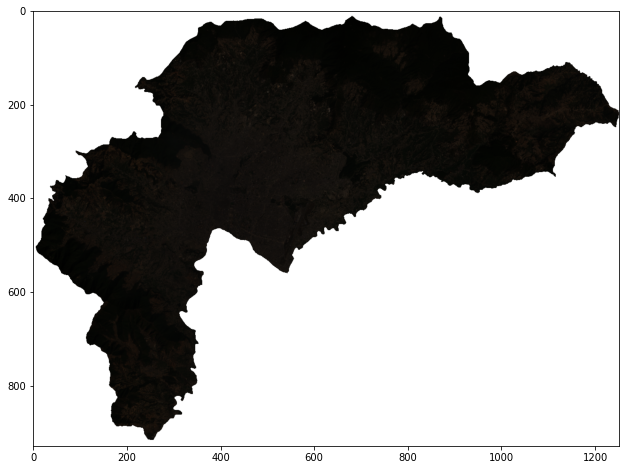

In [15]:
fig,ax=plt.subplots(figsize=(12,8))
plt.imshow(composite_normalized_RGB)

# Now lets work with classified image of kathmandu which is in shape file polygon

In [16]:
import geopandas as gpd

In [17]:
kathmandu_classified_shape_file=gpd.read_file(r"C:\Users\user\Downloads\GIS_self_project\kathmandu_classified_deep_learning.shp")

In [18]:
kathmandu_classified_shape_file.columns

Index(['OBJECTID', 'Id', 'Classname', 'Shape_Leng', 'Shape_Area', 'labels',
       'geometry'],
      dtype='object')

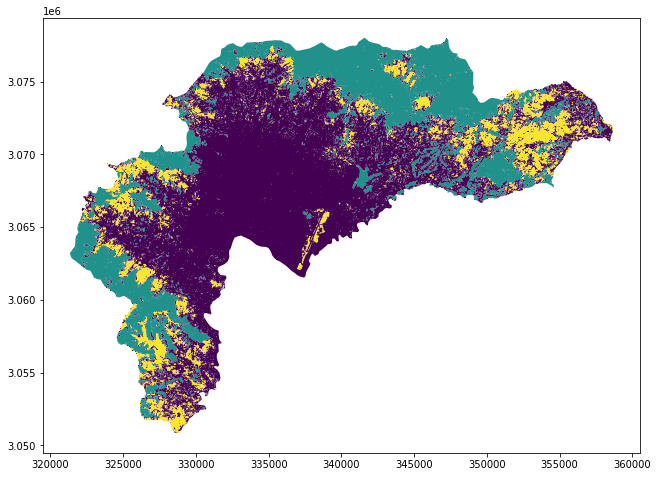

In [19]:
from matplotlib import colors
fig,ax=plt.subplots(figsize=(20,8))

kathmandu_classified_shape_file.plot(ax=ax,column="labels")

In [20]:
kathmandu_classified_shape_file.shape

(17405, 7)

# Now lets prepare the features and labels

In [21]:
kathmandu_raster_array_8_bands=kathmandu_dataset_raster.read()
print(kathmandu_raster_array_8_bands.shape)

(8, 929, 1252)


In [22]:
kathmandu_classified_shape_file.crs

{'init': 'epsg:32645'}

In [23]:
kathmandu_dataset_raster.crs

CRS.from_dict(init='epsg:32645')

Now to get geometry  from  kathmandu file

In [24]:
geoms=kathmandu_classified_shape_file.geometry.values
print(len(geoms))
type(geoms)

17405


geopandas.array.GeometryArray

POLYGON ((334131.0935061136 3077694.32021069, 334191.0935061127 3077694.32021069, 334174.5014040628 3077623.871468777, 334131.0935061136 3077694.32021069))
<class 'shapely.geometry.polygon.Polygon'>


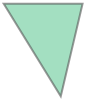

In [27]:
first_geometry=geoms[5]
print(first_geometry)
print(type(first_geometry))
first_geometry

Lets convert it into geojason file

now lets mask the first features

# Now lets define the function to extract the features.

In [371]:
X9=np.array([], dtype=np.int8).reshape(8,0)
Y9=np.array([], dtype=np.string_)
for i in range(len(geoms)):
    from shapely.geometry import mapping
    one_geojason_file=[mapping(geoms[i])]
    from rasterio.mask import mask
    out_image, out_transform = mask(kathmandu_dataset_raster,one_geojason_file,crop=True)
    out_image_trimmed_0 = out_image[:,~np.all(out_image == 0, axis=0)]
    out_image_trimmed_255 = out_image_trimmed_0[:,~np.all(out_image_trimmed_0 == 255, axis=0)]
    X9= np.hstack((X9,out_image_trimmed_255))
    def split(word): 
        return list(word) 
    lables_merege = (str(kathmandu_classified_shape_file["labels"][i]))*out_image_trimmed_255.shape[1]
    splitted=split(lables_merege)
    Y9= np.append(Y9,splitted)    

In [372]:
print(X9.shape)

(8, 1576341)


In [373]:
print(Y9.shape)

(1576341,)


In [374]:
Y_final=Y9.reshape(1,len(Y9))
print(Y_final.shape)

Y_final_reversed=Y9.reshape(len(Y9))
print(Y_final_reversed.shape)

(1, 1576341)
(1576341,)


Now lets do one-hot encoding


In [375]:
print(type(Y_final))


<class 'numpy.ndarray'>


In [376]:
import pandas as pd

dataframe=pd.DataFrame({"Class":list(Y_final_reversed)})
dataframe.head()

,Class
0,1
1,1
2,1
3,1
4,1


In [377]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(sparse=False)

In [378]:
New_Y=ohe.fit_transform(dataframe[["Class"]])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [379]:
print(New_Y.shape)

(1576341, 3)


In [380]:
print(New_Y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [381]:
Final_label_encoded=New_Y.T
print(Final_label_encoded)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [382]:
print(Final_label_encoded.shape)

(3, 1576341)


# Now Lets build the L_layer neural network

## Step 1: Initialization

In [383]:
def initialization_of_parameters(list_nodes):
    np.random.seed(3) #Random seed is change for example set back to 3
    Number_of_layer=len(list_nodes)
    
    parameters={}
    
    
    for l in range(1,Number_of_layer): #to make one less parameter matix than number of layers and match the number W1,W2,b1,b2 etc
        
        parameters["W"+ str(l)]=np.random.randn(list_nodes[l],list_nodes[l-1])*0.01
        parameters["b"+ str(l)]=np.zeros((list_nodes[l],1))
        
        
        assert ( parameters["W"+str(l)].shape == (list_nodes[l],list_nodes[l-1]))
        assert (parameters["b"+str(l)].shape==(list_nodes[l],1))
        
    return  parameters  

## Step 2: Forward propagation with relu for all layer except the last , where we will be using the softmax activation function 

1) First define linear forward propagation

In [384]:
def linear_forward(X,W,b):
    
    Z=np.dot(W,X)+b
    
    assert (Z.shape== (W.shape[0],X.shape[1]))
    storage_linear_forward=(X,W,b)
    
    return Z,storage_linear_forward

Now lets define the Relu activation function

In [385]:
def sigmoid(Z):

    
    A = 1/(1+np.exp(-Z))
    storage_sigmoid = Z
    
    return A, storage_sigmoid

Now lets define softmax activation function

In [419]:
def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    storage_relu = Z 
    return A, storage_relu

In [420]:
def softmax(Z):
    expZ = np.exp(Z)
    A=expZ / expZ.sum(axis=0, keepdims=True)
    
    storage_softmax=Z
    
    return A, storage_softmax

In [425]:
def linear_forward_with_activation(X,W,b,activation_type):
    
    if activation_type== "relu":
        Z,storage_linear_forward= linear_forward(X,W,b)
        A,storage_Z=relu(Z)
        
    elif activation_type == "softmax":
        Z,storage_linear_forward=linear_forward(X,W,b)
        A,storage_Z=softmax(Z)
        
    assert (A.shape==(Z.shape))
    
    storage_linear_forward_with_activation=(storage_linear_forward,storage_Z ) #to store X,W,b,Z 
    
    return A,storage_linear_forward_with_activation  

In [428]:
def forward_propagation_for_n_layers(X,parameters):
    
    Number_of_layer=len(parameters)//2
    
    storage_forward_propagation_for_all_layers=[]
    A=X
    
    for l in range(1,Number_of_layer):
        A_previous= A
        
        A,storage_linear_forward_with_activation_sigmoid=linear_forward_with_activation(A_previous,
                            parameters["W"+str(l)],parameters["b"+str(l)],activation_type="relu")
       
        storage_forward_propagation_for_all_layers.append(storage_linear_forward_with_activation_sigmoid) #to store X,W,b,Z 
        
        
        
    A_last,storage_linear_forward_with_activation_softmax=linear_forward_with_activation(A ,
                 parameters["W"+str(Number_of_layer)],parameters["b"+str(Number_of_layer)],activation_type="softmax")
    

    storage_forward_propagation_for_all_layers.append(storage_linear_forward_with_activation_softmax)
                                                                                             
    assert(A_last.shape==(parameters["W"+str(Number_of_layer)].shape[0],X.shape[1]))
    
    return A_last, storage_forward_propagation_for_all_layers    

# Now lets define the cost function and calculate the cost

In [429]:
def cost_cal(A_last,Y):
    cost = - np.sum(np.multiply(np.log(A_last),Y))
    
    cost = np.squeeze(cost)
    assert (cost.shape==())
    
    return cost    

# Now lets define the funtion for backward propagation and implement it.

In [430]:
def linear_backward(dZ, storage_linear_forward):
  
    A_previous, W, b = storage_linear_forward
    m = A_previous.shape[1]

    
    dW = dZ @ A_previous.T
    db = np.sum(dZ, axis=1, keepdims=True)
    dA_previous = W.T @ dZ
   
    
    assert (dA_previous.shape == A_previous.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_previous, dW, db

In [431]:
def sigmoid_backward(dA, storage_Z ):
    
    Z = storage_Z 
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [432]:
def relu_backward(dA, storage_Z ):

    Z = storage_Z 
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [433]:
def softmax_backward(dA,storage_Z ):
    Z = storage_Z
    dZ =dA * 1 #(From the derivatives of cost entropy and softmax activation function)
    
    assert (dZ.shape == Z.shape)
    return dZ

In [434]:
def linear_activation_backward(dA, storage_linear_forward_with_activation, activation_type):
    
    storage_linear_forward,storage_Z=storage_linear_forward_with_activation
    
    if activation_type == "softmax":
        
        dZ = softmax_backward(dA,storage_Z )
        dA_previous, dW, db = linear_backward(dZ, storage_linear_forward)
        
    elif activation_type == "relu":
       
        dZ = relu_backward(dA, storage_Z)
        dA_previous, dW, db = linear_backward(dZ, storage_linear_forward)

    
    return dA_previous, dW, db

In [489]:
def L_model_backward(A_last, Y, storage_forward_propagation_for_all_layers  ):

    gradients = {}
    Number_of_layer= len( storage_forward_propagation_for_all_layers ) # the number of layers
    m = A_last.shape[1]
    Y = Y.reshape(A_last.shape)
    
    # Initializing the backpropagation
  
    dA_last = A_last-Y
    
    current_storage = storage_forward_propagation_for_all_layers[Number_of_layer-1]
    gradients["dA" + str(Number_of_layer-1)], gradients["dW" + str(Number_of_layer)], gradients["db" + str(Number_of_layer)] = linear_activation_backward(dA_last, current_storage, "softmax")
    
#     for relu layers
    for l in reversed(range(Number_of_layer-1)):
        
        current_storage =  storage_forward_propagation_for_all_layers [l]
        dA_previous_temp, dW_temp, db_temp = linear_activation_backward(gradients["dA" + str(l + 1)], current_storage, "relu")
        gradients["dA" + str(l)] = dA_previous_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp
      

    return gradients

# Now lets update the parameters

In [490]:
def update_parameters(parameters, gradients, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    return parameters

# Almost completed now lets merge all in same funtion to a defination L- layer Neural network

In [564]:
def L_layer_neural_network_model(X, Y, list_nodes, learning_rate = 0.0075, iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                  
    
    #step:1
    parameters =initialization_of_parameters(list_nodes)
   
    # Loop (gradient descent)
    for i in range(0,iterations):

        # Step 2: Forward propagation: linear to sigmoid and linear to softmax
        A_last, storage_forward_propagation_for_all_layers = forward_propagation_for_n_layers(X,parameters)
    
        # step 3 : Calculation of cost.
        cost = cost_cal(A_last,Y)
    
        # step 4: Backward propagation.
        gradients = L_model_backward(A_last, Y, storage_forward_propagation_for_all_layers )
    
        #step 5: Update parameters.
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [565]:
def predict(X,parameters):
 # Forward propagation
    probability, param_storage = forward_propagation_for_n_layers(X,parameters)
    return probability, param_storage  #gives last layer output.

# Now lets check the accuracy of the model

In [654]:
def accuracy(probability,true_class):
    
    print(f"The size of output probability :{probability.size} ")
    unique_probability=np.unique(probability)
    print(f"The size of unique output probability :{unique_probability.size} ")
    print(f"The size of true class :{true_class.size} ")
    
    predicted_class=(probability== probability.max(axis=0)).astype(int)
    label=np.array([1,2,3]).reshape(3,1)
    multiply_1=label* predicted_class
    multiply_2=label*true_class
    
    final_labels_predicted=np.max(multiply_1,axis=0)
    final_labels_true=np.max(multiply_2,axis=0)
    
    diff=(final_labels_predicted-final_labels_true)
    count_zero=np.count_nonzero(diff==0)
    
    
    m=true_class.shape[1]
    
    Accuracy= (count_zero/m)*100
    
    print(f"Accuracy of model is {Accuracy}%")
    return final_labels_predicted, final_labels_true  

# Now lets split the original data into training and test and apply it in the model

In [655]:
X_original=X9

print(X_original)
print(X_original.shape)


[[ 9033  8993 65536 ... 65536 65536 65536]
 [ 8407  8321 65536 ... 65536 65536 65536]
 [ 7979  8201 65536 ... 65536 65536 65536]
 ...
 [12377 13456 65536 ... 65536 65536 65536]
 [ 9566 10279 65536 ... 65536 65536 65536]
 [ 7432  7995 65536 ... 65536 65536 65536]]
(8, 1576341)


In [656]:
Y_final=Y9.reshape(1,len(Y9))

In [657]:
Final_label_encoded=New_Y.T

In [658]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_original.T,Final_label_encoded.T,test_size=0.998,random_state=32)

In [659]:
print(X_train.T)
print(X_train.T.shape)

[[10852 65536 65536 ... 65536 65536  9281]
 [10295 65536 65536 ... 65536 65536  8588]
 [ 9875 65536 65536 ... 65536 65536  7966]
 ...
 [13669 65536 65536 ... 65536 65536 12234]
 [12707 65536 65536 ... 65536 65536  9645]
 [10889 65536 65536 ... 65536 65536  8323]]
(8, 3152)


In [660]:
print(y_train.T)
print(y_train.T.shape)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]
(3, 3152)


In [661]:
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_train,y_train,test_size=0.3,random_state=42)

Lets normalize the X_train and X_test

In [662]:
def normalize(band_in_array):
    maximum_value,minimum_value=np.max(band_in_array),np.min(band_in_array)
    normalize_band_array= (band_in_array-minimum_value)/(maximum_value-minimum_value)
    return(normalize_band_array)

In [663]:
X_train_normalized=normalize(X_train_1.T)

In [641]:
X_test_normalized=normalize(X_test_1.T)

# Now lets train the neural network with original training data from shape file

Cost after iteration 0: 2423.538740
Cost after iteration 100: 136126.499042
Cost after iteration 200: 117674.840648
Cost after iteration 300: 156481.535556
Cost after iteration 400: 38605.385865


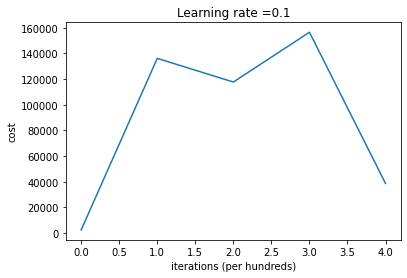

In [739]:
list_nodes=[8,20,4,3]

best_parameters=L_layer_neural_network_model(X_train_normalized,y_train_1.T, list_nodes, learning_rate = 0.1, iterations = 500, print_cost=True)

In [747]:
best_output,param_train=predict(X_train_normalized,best_parameters)

In [748]:
print(best_output)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.17858574e-46 1.17858574e-46 1.17858574e-46 ... 1.17858574e-46
  1.17858574e-46 1.17858574e-46]
 [1.38264872e-50 1.38264872e-50 1.38264872e-50 ... 1.38264872e-50
  1.38264872e-50 1.38264872e-50]]


In [749]:
true_class=y_train_1.T
print(y_train_1.T)
accuracy(best_output,true_class)

[[0. 1. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
The size of output probability :6618 
The size of unique output probability :3 
The size of true class :6618 
Accuracy of model is 59.38349954669084%


(array([1, 1, 1, ..., 1, 1, 1]), array([3., 1., 2., ..., 1., 2., 1.]))

In [750]:
best_output_test,param_storage_test=predict(X_test_normalized, best_parameters)

In [751]:
final_labels, final_labels=accuracy(best_output_test,y_test_1.T)
print(final_labels_predicted)
print( final_labels_true)

The size of output probability :2838 
The size of unique output probability :3 
The size of true class :2838 
Accuracy of model is 61.41649048625793%
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [752]:
best_output_train,param_storage_train=predict(X9,best_parameters)

In [753]:
best_output_train.shape

(3, 1576341)

In [755]:
predicted_class=(best_output_train== best_output_train.max(axis=0)).astype(int)
label=np.array([1,2,3]).reshape(3,1)
multiply_1=label* predicted_class

final_labels_predicted=np.max(multiply_1,axis=0)

In [756]:
final_labels_predicted.shape

(1576341,)

In [757]:
print(np.unique(final_labels_predicted))

[1]
